In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import itertools
# Robust scaler is used to scale the features to median and IQR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor


In [2]:
df = pd.read_csv('results_mixed.csv')
#df = df.sort_values(by=['publisher_number', 'subscriber_number', 'message_size'])

# Convert message_size
df['message_size'] = df['message_size'].map({1024: 1, 2048: 2, 4096: 4, 8192: 8, 16384: 16})

# Convert ram_usage and database_size to kilobytes
df['ram_usage'] = df['ram_usage'] / 1024
df['database_size'] = df['database_size'] / 1024
#df = df[df['database_size'] <= 1000]

In [3]:
print(df['publisher_number'].unique())
print(df['subscriber_number'].unique())
print(df['message_size'].unique())

[ 4  1  8  3  2  5 16  6  7 64 32]
[ 7 32  3  4  6  1  8  5  2 64 16]
[ 4  1  2  8 16]


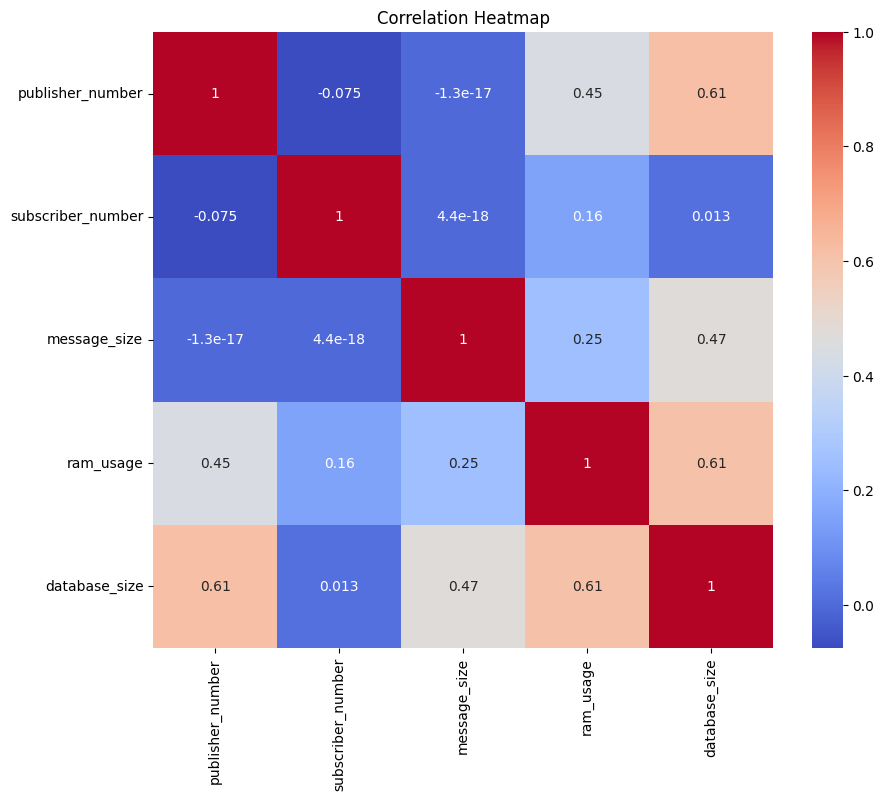

In [4]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


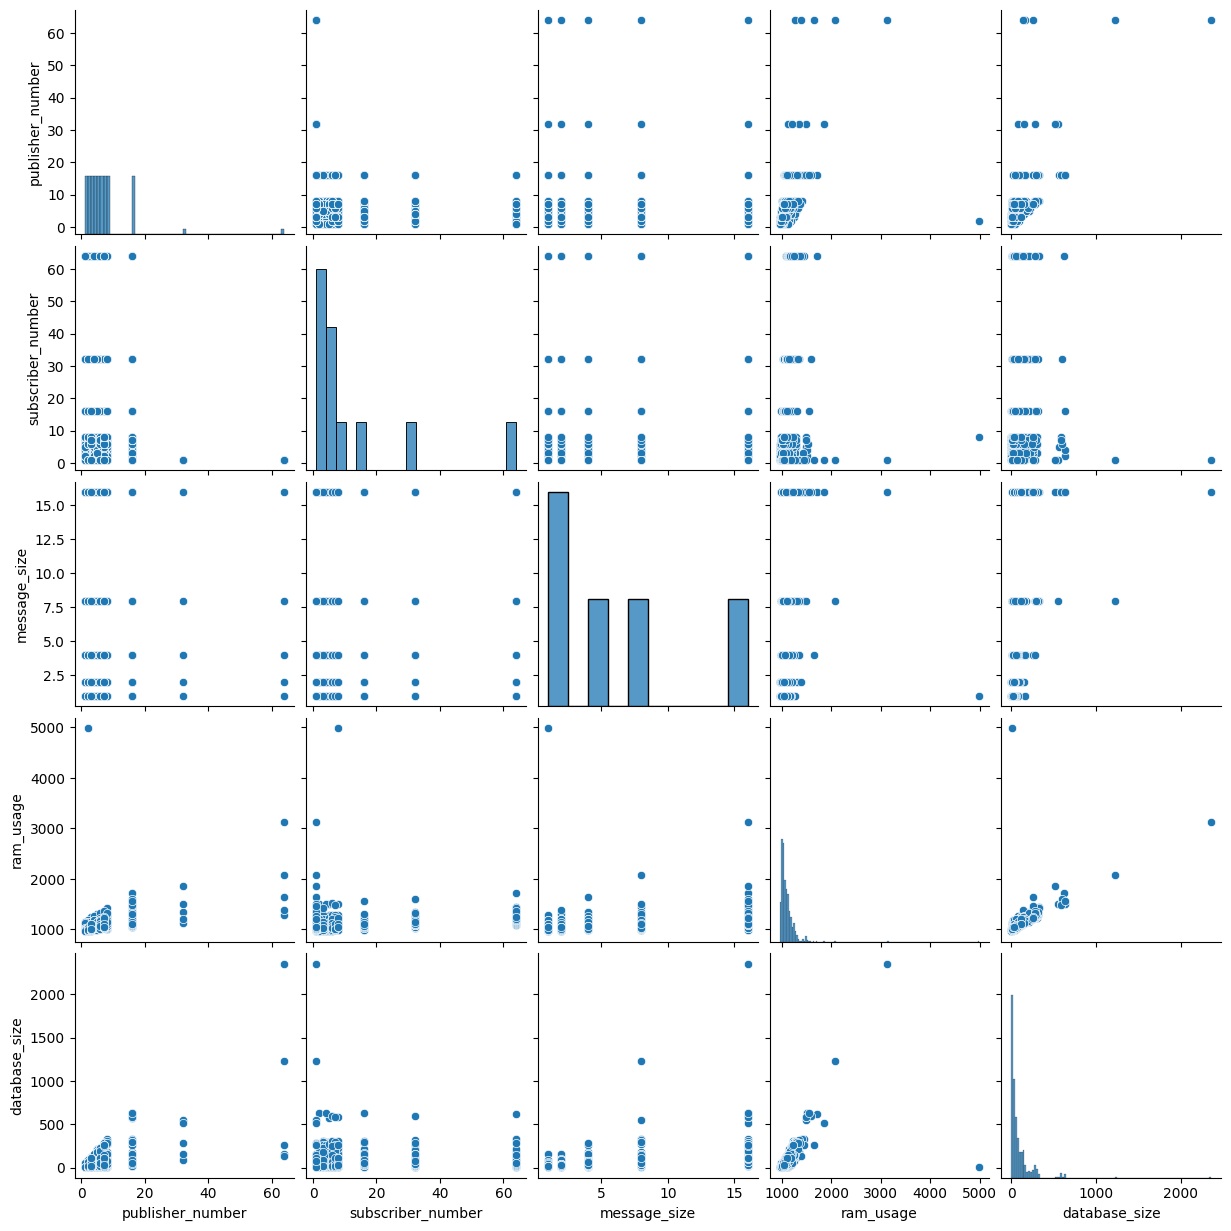

In [5]:
sns.pairplot(df)
plt.show()


In [6]:
# Normalize the data frame and save it in a different variable
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[['publisher_number', 'subscriber_number', 'message_size', 'ram_usage', 'database_size']] = scaler.fit_transform(df[['publisher_number', 'subscriber_number', 'message_size', 'ram_usage', 'database_size']])


# Split the data into training and testing sets
X = df_scaled[['publisher_number', 'subscriber_number', 'message_size']]
y = df_scaled['database_size']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1))

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

# Predict on the test set with both models
lr_y_pred = model.predict(X_test)
rf_y_pred = rf_model.predict(X_test)
gb_y_pred = gb_model.predict(X_test)
xgb_y_pred = xgb_model.predict(X_test)
nn_y_pred = nn_model.predict(X_test).flatten()

# Evaluate the models
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

nn_mse = mean_squared_error(y_test, nn_y_pred)
nn_r2 = r2_score(y_test, nn_y_pred)

print(f'Linear Regression - Mean Squared Error: {lr_mse}, R^2 Score: {lr_r2}')
print(f'Random Forest - Mean Squared Error: {rf_mse}, R^2 Score: {rf_r2}')
print(f'Gradient Boosting - Mean Squared Error: {gb_mse}, R^2 Score: {gb_r2}')
print(f'XGBoost - Mean Squared Error: {xgb_mse}, R^2 Score: {xgb_r2}')
print(f'Neural Network - Mean Squared Error: {nn_mse}, R^2 Score: {nn_r2}')

/Users/tugrul/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Linear Regression - Mean Squared Error: 3.8005578223410637, R^2 Score: 0.5214230586789081
Random Forest - Mean Squared Error: 2.6610969573604804, R^2 Score: 0.6649071789077612
Gradient Boosting - Mean Squared Error: 2.4331622013246967, R^2 Score: 0.6936093651297777
XGBoost - Mean Squared Error: 1.8736879487815234, R^2 Score: 0.7640599381893626
Neural Network - Mean Squared Error: 2.4113949815825153, R^2 Score: 0.6963503547245263


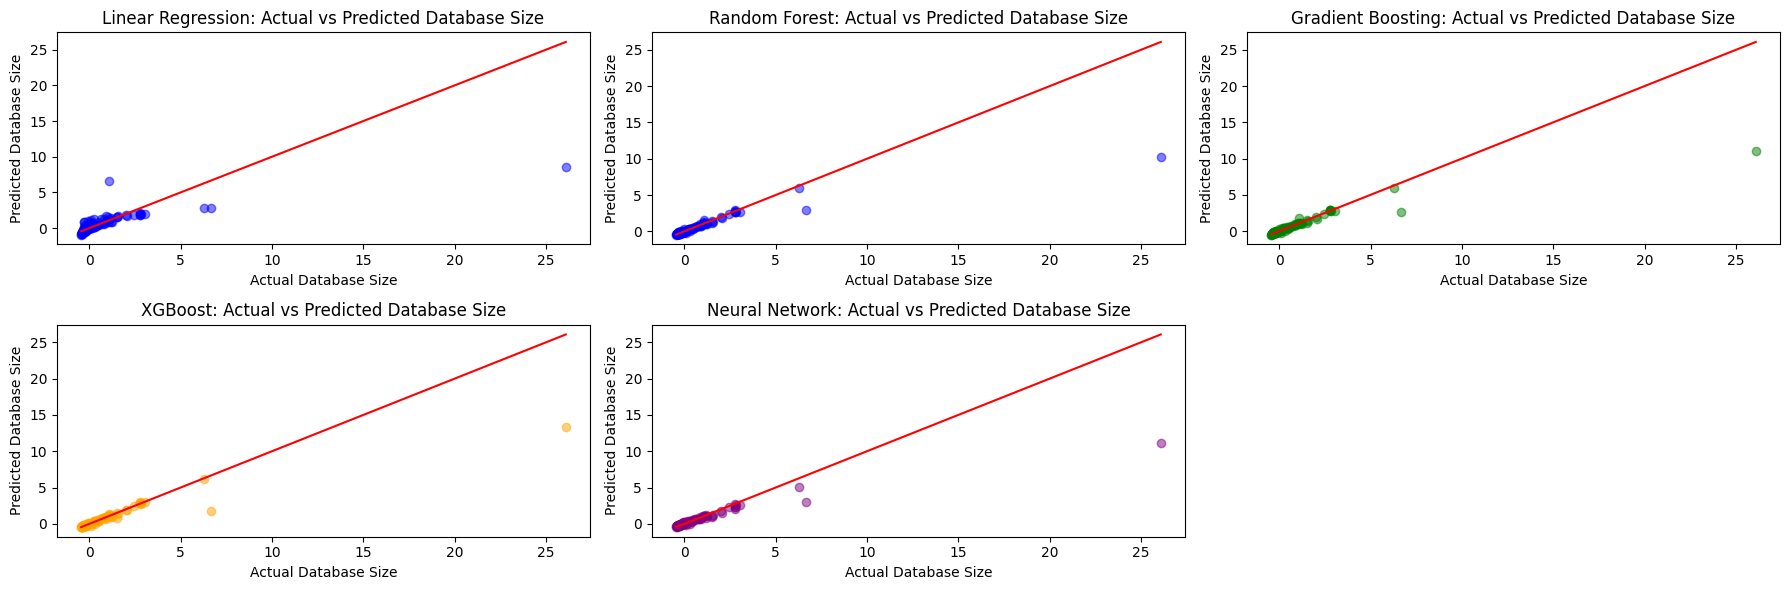

In [7]:
plt.figure(figsize=(18, 6))
# Linear Regression
plt.subplot(2, 3, 1)
plt.scatter(y_test, lr_y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Linear Regression: Actual vs Predicted Database Size')

# Random Forest
plt.subplot(2, 3, 2)
plt.scatter(y_test, rf_y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Random Forest: Actual vs Predicted Database Size')

# Gradient Boosting
plt.subplot(2, 3, 3)
plt.scatter(y_test, gb_y_pred, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Gradient Boosting: Actual vs Predicted Database Size')

# XGBoost
plt.subplot(2, 3, 4)
plt.scatter(y_test, xgb_y_pred, color='orange', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('XGBoost: Actual vs Predicted Database Size')

# Neural Network
plt.subplot(2, 3, 5)
plt.scatter(y_test, nn_y_pred, color='purple', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Neural Network: Actual vs Predicted Database Size')

plt.tight_layout()
plt.show()


In [14]:
# Define the values for each input
publisher_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64]
subscriber_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64]
message_sizes = [1, 2, 4, 8, 16]

# Generate all combinations of the inputs
combinations = list(itertools.product(publisher_numbers, subscriber_numbers, message_sizes))

# Create a DataFrame from the combinations
input_data = pd.DataFrame(combinations, columns=['publisher_number', 'subscriber_number', 'message_size'])

# If there exists a database size in dataframe for given inputs, use it, otherwise Predict database sizes for the combinations using XGBoost
input_data['predicted_database_size'] = 0
for index, row in input_data.iterrows():
    if df[(df['publisher_number'] == row['publisher_number']) & (df['subscriber_number'] == row['subscriber_number']) & (df['message_size'] == row['message_size'])].shape[0] > 0:
        input_data.at[index, 'predicted_database_size'] = df[(df['publisher_number'] == row['publisher_number']) & (df['subscriber_number'] == row['subscriber_number']) & (df['message_size'] == row['message_size'])]['database_size'].values[0]
    else:
        input_data.at[index, 'predicted_database_size'] = xgb_model.predict(scaler.transform([[row['publisher_number'], row['subscriber_number'], row['message_size']]]))[0]

# Display the catalog
display(input_data)

# Optionally, save the catalog to a CSV file
input_data.to_csv('xgboost_combinations_catalog.csv', index=False)


/var/folders/wf/h4cmwskx1rxch7ts3ytb_7cr0000gn/T/ipykernel_58684/1940222437.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.at[index, 'predicted_database_size'] = df[(df['publisher_number'] == row['publisher_number']) & (df['subscriber_number'] == row['subscriber_number']) & (df['message_size'] == row['message_size'])]['database_size'].values[0]
/Users/tugrul/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/tugrul/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/tugrul/Library/Python/3.9/lib/python/site-packages/sklearn/base.py

,publisher_number,subscriber_number,message_size,predicted_database_size
0,1,1,1,2.400000
1,1,1,2,2.200000
2,1,1,4,8.400000
3,1,1,8,16.400000
4,1,1,16,16.200000
...,...,...,...,...
600,64,64,1,3.176156
601,64,64,2,3.135980
602,64,64,4,3.135980
603,64,64,8,3.135980


In [9]:
# Remove the rows that has database_size > 500
df = df[df['database_size'] <= 500]


In [10]:
# Normalize the data frame and save it in a different variable
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled[['publisher_number', 'subscriber_number', 'message_size', 'ram_usage', 'database_size']] = scaler.fit_transform(df[['publisher_number', 'subscriber_number', 'message_size', 'ram_usage', 'database_size']])


# Split the data into training and testing sets
X = df_scaled[['publisher_number', 'subscriber_number', 'message_size']]
y = df_scaled['database_size']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1))

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

# Train the model
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2, verbose=0)

# Predict on the test set with both models
lr_y_pred = model.predict(X_test)
rf_y_pred = rf_model.predict(X_test)
gb_y_pred = gb_model.predict(X_test)
xgb_y_pred = xgb_model.predict(X_test)
nn_y_pred = nn_model.predict(X_test).flatten()

# Evaluate the models
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

nn_mse = mean_squared_error(y_test, nn_y_pred)
nn_r2 = r2_score(y_test, nn_y_pred)

print(f'Linear Regression - Mean Squared Error: {lr_mse}, R^2 Score: {lr_r2}')
print(f'Random Forest - Mean Squared Error: {rf_mse}, R^2 Score: {rf_r2}')
print(f'Gradient Boosting - Mean Squared Error: {gb_mse}, R^2 Score: {gb_r2}')
print(f'XGBoost - Mean Squared Error: {xgb_mse}, R^2 Score: {xgb_r2}')
print(f'Neural Network - Mean Squared Error: {nn_mse}, R^2 Score: {nn_r2}')

/Users/tugrul/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Linear Regression - Mean Squared Error: 0.4114699467166535, R^2 Score: 0.6632177036642485
Random Forest - Mean Squared Error: 0.07396054700921971, R^2 Score: 0.9394643447017872
Gradient Boosting - Mean Squared Error: 0.07888418596875997, R^2 Score: 0.9354344162748054
XGBoost - Mean Squared Error: 0.08135367739877557, R^2 Score: 0.9334131726792073
Neural Network - Mean Squared Error: 0.05897544618844326, R^2 Score: 0.9517294364916358


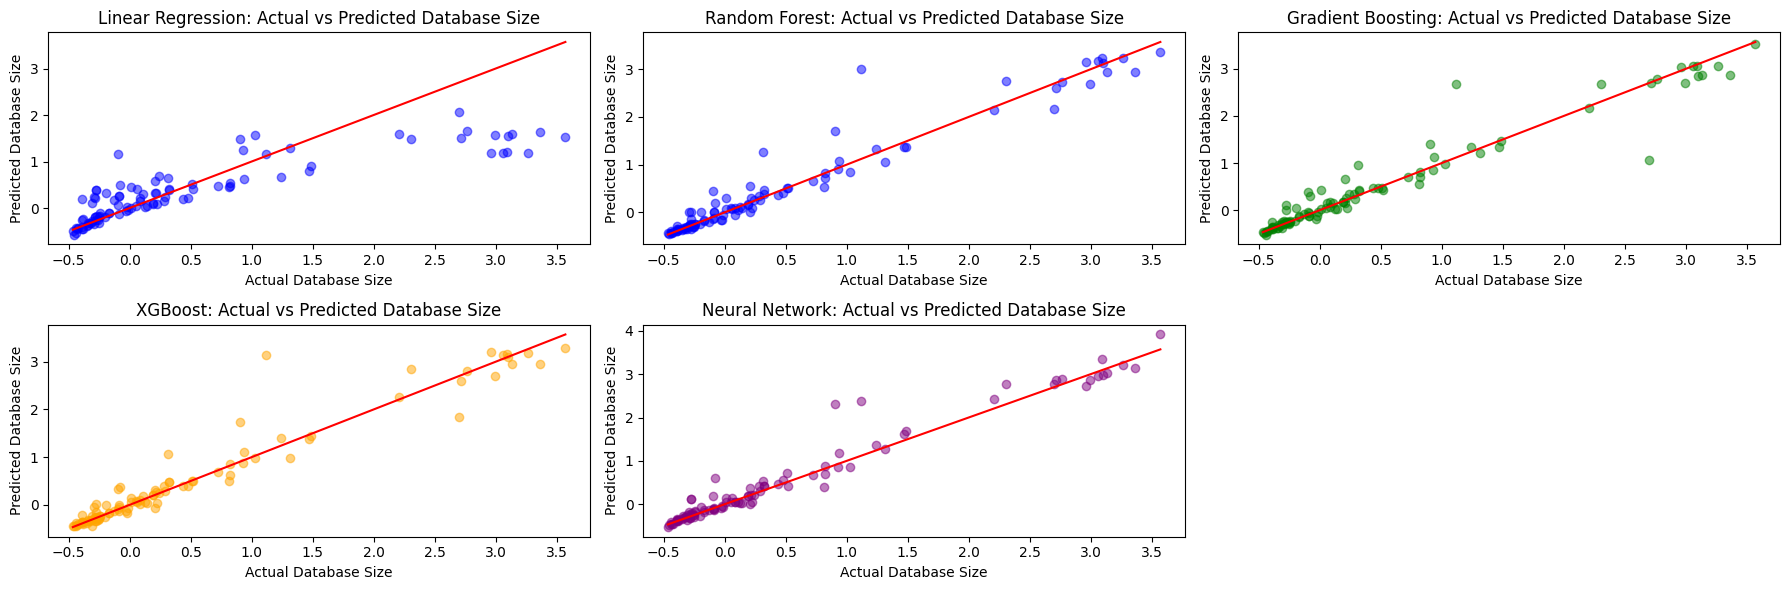

In [11]:
plt.figure(figsize=(18, 6))
# Linear Regression
plt.subplot(2, 3, 1)
plt.scatter(y_test, lr_y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Linear Regression: Actual vs Predicted Database Size')

# Random Forest
plt.subplot(2, 3, 2)
plt.scatter(y_test, rf_y_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Random Forest: Actual vs Predicted Database Size')

# Gradient Boosting
plt.subplot(2, 3, 3)
plt.scatter(y_test, gb_y_pred, color='green', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Gradient Boosting: Actual vs Predicted Database Size')

# XGBoost
plt.subplot(2, 3, 4)
plt.scatter(y_test, xgb_y_pred, color='orange', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('XGBoost: Actual vs Predicted Database Size')

# Neural Network
plt.subplot(2, 3, 5)
plt.scatter(y_test, nn_y_pred, color='purple', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Database Size')
plt.ylabel('Predicted Database Size')
plt.title('Neural Network: Actual vs Predicted Database Size')

plt.tight_layout()
plt.show()


In [15]:
# Define the values for each input
publisher_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64]
subscriber_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64]
message_sizes = [1, 2, 4, 8, 16]

# Generate all combinations of the inputs
combinations = list(itertools.product(publisher_numbers, subscriber_numbers, message_sizes))

# Create a DataFrame from the combinations
input_data = pd.DataFrame(combinations, columns=['publisher_number', 'subscriber_number', 'message_size'])


# If there exists a database size in dataframe for given inputs, use it, otherwise Predict database sizes for the combinations using XGBoost
input_data['predicted_database_size'] = 0
for index, row in input_data.iterrows():
    if df[(df['publisher_number'] == row['publisher_number']) & (df['subscriber_number'] == row['subscriber_number']) & (df['message_size'] == row['message_size'])].shape[0] > 0:
        input_data.at[index, 'predicted_database_size'] = df[(df['publisher_number'] == row['publisher_number']) & (df['subscriber_number'] == row['subscriber_number']) & (df['message_size'] == row['message_size'])]['database_size'].values[0]
    else:
        input_data.at[index, 'predicted_database_size'] = xgb_model.predict(scaler.transform([[row['publisher_number'], row['subscriber_number'], row['message_size']]]))[0]


# Display the catalog
display(input_data)

# Optionally, save the catalog to a CSV file
input_data.to_csv('xgboost_combinations_catalog_db_lower_500.csv', index=False)


/var/folders/wf/h4cmwskx1rxch7ts3ytb_7cr0000gn/T/ipykernel_58684/1688968835.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  input_data.at[index, 'predicted_database_size'] = df[(df['publisher_number'] == row['publisher_number']) & (df['subscriber_number'] == row['subscriber_number']) & (df['message_size'] == row['message_size'])]['database_size'].values[0]
/Users/tugrul/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/tugrul/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/tugrul/Library/Python/3.9/lib/python/site-packages/sklearn/base.py

,publisher_number,subscriber_number,message_size,predicted_database_size
0,1,1,1,2.400000
1,1,1,2,2.200000
2,1,1,4,8.400000
3,1,1,8,16.400000
4,1,1,16,16.200000
...,...,...,...,...
600,64,64,1,3.176156
601,64,64,2,3.135980
602,64,64,4,3.135980
603,64,64,8,3.135980
